# Correlation scores for the (dataset, partitioner) pairs

The first (this) section provides the exploration of the correlation of the accuracy (on the final left out set from model train in FL manner) and the heterogeneity metric (hellinger distance) of the partitions (train set).



In [29]:
import pandas as pd
import numpy as np
from IPython.display import display
import dataframe_image as dfi
from typing import Literal
import seaborn as sns

In [2]:
DISPLAY_DATAFRAMES = True
SAVE_DATAFRAMES = False
PLOT_RESULTS = True

In [3]:
res_dict = {}
acc_dict = {}
hetero_dict = {}

corrs = {}

base_acc_path = "/home/FL-heterogeneity/results/res10092024/"
base_hetero_path = "/home/FL-heterogeneity/res-het-updated-dataset-size"

In [21]:
acc_cols = {
    "IidPartitioner": ["num_partitions"],
    "DirichletPartitioner": ["num_partitions", "alpha"],
    p2: ["num_partitions", "num_classes_per_partition"],
}


def read_data(
    ds_name,
    partitioner_name,
    base_acc_path=base_acc_path,
    base_hetero_path=base_hetero_path,
    mode: Literal["single-seed", "multi-seed", "mean"] = "single-seed",
):
    # Read hetero
    path = f"{base_hetero_path}/{ds_name}/{partitioner_name}/compute_hellinger_distance.csv"
    metrics = pd.read_csv(path)
    metrics = metrics.drop_duplicates()

    if mode == "single-seed":
        hetero = metrics.loc[metrics["fds_seed"] == 42]
    elif mode == "multi-seed":
        hetero = metrics
    elif mode == "mean":
        hetero = metrics.groupby(acc_cols[partitioner_name])["metric_value"].mean().to_frame()

    try:
        hetero = hetero[acc_cols[partitioner_name] + ["metric_value"]]
    except:
        hetero = hetero[["metric_value"]]

    # Read acc
    path_acc = (
        f"{base_acc_path}"
        + f"{ds_name}/{partitioner_name}/Adam"
        + "{}"
        + "/test_res.csv"
    )
    acc = pd.read_csv(path_acc)
    acc = acc[acc_cols[partitioner_name] + ["eval/acc"]]

    # Merge results
    res = acc.merge(hetero, on=acc_cols[partitioner_name])
    return res, acc, hetero

def save_acc_results(acc, ds_name, partitioner_name):
    dfi.export(
                acc.loc[:, acc_cols[partitioner_name] + ["eval/acc"]]
                .set_index("num_partitions")
                .style.background_gradient(
                    subset="eval/acc", vmin=0, vmax=1, cmap="Greens"
                ),
                f"/home/FL-heterogeneity/plots/acc/{ds_name}_{partitioner_name}_test_acc_df.png",
                table_conversion="matplotlib",
            )

mnist, IidPartitioner correlation: -0.9956622141649975
cifar10, IidPartitioner correlation: -0.8541253643192379
cifar100, IidPartitioner correlation: -0.9122795663286526

mnist, IidPartitioner


,num_partitions,eval/acc,metric_value
0,3,0.9902,0.006936
1,10,0.9906,0.013577
2,30,0.9853,0.025672
3,100,0.9814,0.048099
4,300,0.9738,0.083463
5,1000,0.9509,0.160284


cifar10, IidPartitioner


,num_partitions,eval/acc,metric_value
0,3,0.6088,0.007855
1,10,0.5715,0.015566
2,30,0.5258,0.025792
3,100,0.4874,0.049345
4,300,0.4839,0.089858
5,1000,0.4433,0.178312


cifar100, IidPartitioner


,num_partitions,eval/acc,metric_value
0,3,0.2592,0.027860
1,10,0.2289,0.054481
2,30,0.1858,0.097593
3,100,0.1610,0.201109
4,300,0.1668,0.411091
5,1000,0.0824,0.657619



mnist, IidPartitioner
cifar10, IidPartitioner
cifar100, IidPartitioner
mnist, DirichletPartitioner correlation: -0.40436834206694927
cifar10, DirichletPartitioner correlation: -0.6103781813387034
cifar100, DirichletPartitioner correlation: -0.7337310642489856

mnist, DirichletPartitioner


,num_partitions,alpha,eval/acc,metric_value
0,3,0.1,0.8852,0.466256
1,3,0.1,0.8852,0.567989
2,3,0.3,0.9867,0.372251
3,3,0.3,0.9867,0.440141
4,3,1.0,0.9884,0.228454
...,...,...,...,...
79,1000,10.0,0.9608,0.150137
80,1000,100.0,0.9460,0.082887
81,1000,100.0,0.9460,0.082489
82,1000,1000.0,0.9487,0.074854


cifar10, DirichletPartitioner


,num_partitions,alpha,eval/acc,metric_value
0,3,0.1,0.5169,0.465113
1,3,0.1,0.5169,0.568081
2,3,0.3,0.5492,0.371365
3,3,0.3,0.5492,0.439573
4,3,1.0,0.5990,0.225763
...,...,...,...,...
79,1000,10.0,0.4408,0.157678
80,1000,100.0,0.4500,0.090270
81,1000,100.0,0.4500,0.091285
82,1000,1000.0,0.3912,0.083001


cifar100, DirichletPartitioner


,num_partitions,alpha,eval/acc,metric_value
0,3,0.1,0.1301,0.549480
1,3,0.1,0.1301,0.554582
2,3,0.3,0.1937,0.430788
3,3,0.3,0.1937,0.436921
4,3,1.0,0.2556,0.262776
...,...,...,...,...
79,1000,10.0,NaN,NaN
80,1000,100.0,NaN,NaN
81,1000,100.0,NaN,NaN
82,1000,1000.0,NaN,NaN



mnist, DirichletPartitioner
cifar10, DirichletPartitioner
cifar100, DirichletPartitioner
mnist, PathologicalPartitioner correlation: -0.7074545195482632
cifar10, PathologicalPartitioner correlation: -0.7651186456262624
cifar100, PathologicalPartitioner correlation: -0.7956212041010714

mnist, PathologicalPartitioner


,num_partitions,num_classes_per_partition,eval/acc,metric_value
0,3,0.2,0.5786,0.740690
1,3,0.2,0.5786,0.741209
2,3,0.2,0.5786,0.746081
3,3,0.3,0.5288,0.673967
4,3,0.3,0.5288,0.675921
...,...,...,...,...
157,300,0.1,0.1010,0.826680
158,300,0.1,0.1010,0.826682
159,1000,0.1,0.0958,0.826694
160,1000,0.1,0.0958,0.826694


cifar10, PathologicalPartitioner


,num_partitions,num_classes_per_partition,eval/acc,metric_value
0,3,0.2,0.2563,0.743497
1,3,0.2,0.2563,0.746825
2,3,0.2,0.2563,0.746106
3,3,0.3,0.3311,0.675875
4,3,0.3,0.3311,0.680590
...,...,...,...,...
157,300,0.1,0.1000,0.826905
158,300,0.1,0.1000,0.826905
159,1000,0.1,0.0908,0.826905
160,1000,0.1,0.0908,0.826905


cifar100, PathologicalPartitioner


,num_partitions,num_classes_per_partition,eval/acc,metric_value
0,3,0.2,0.0655,0.746941
1,3,0.2,0.0655,0.746159
2,3,0.2,0.0655,0.748140
3,3,0.3,0.0937,0.678286
4,3,0.3,0.0937,0.675143
...,...,...,...,...
157,300,0.1,0.0569,0.827245
158,300,0.1,0.0569,0.827895
159,1000,0.1,0.0102,0.828535
160,1000,0.1,0.0102,0.828171



mnist, PathologicalPartitioner
cifar10, PathologicalPartitioner
cifar100, PathologicalPartitioner


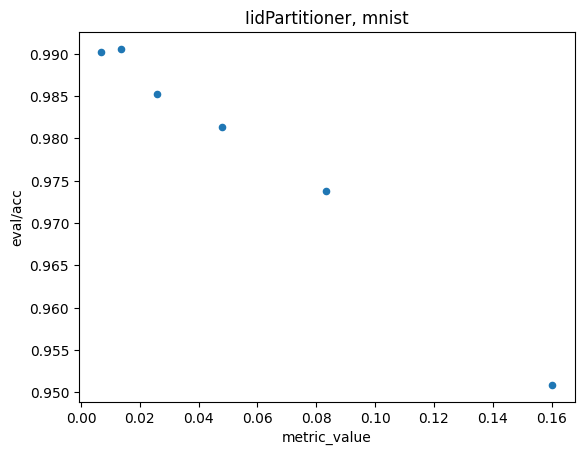

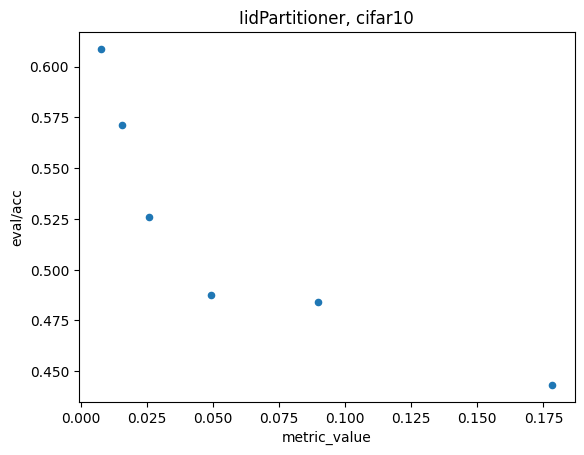

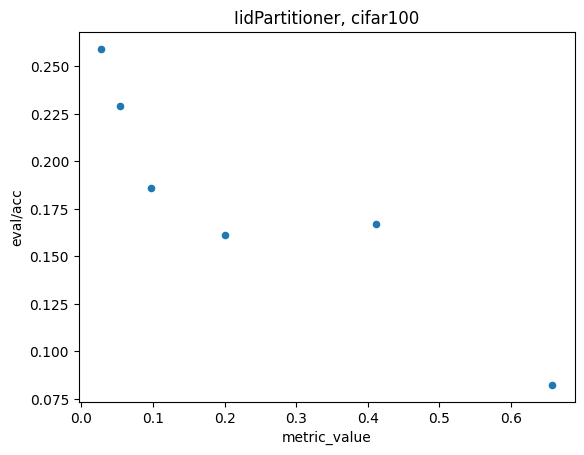

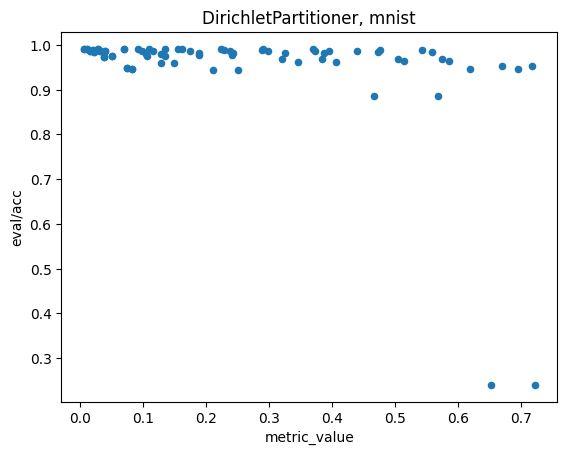

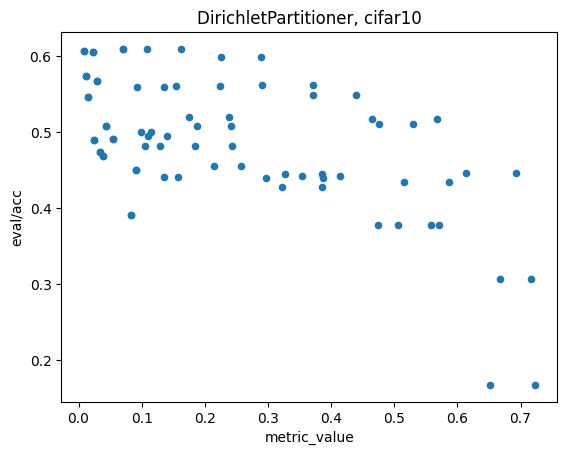

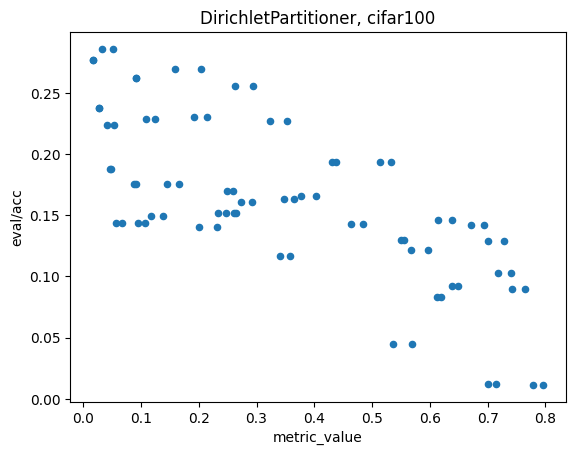

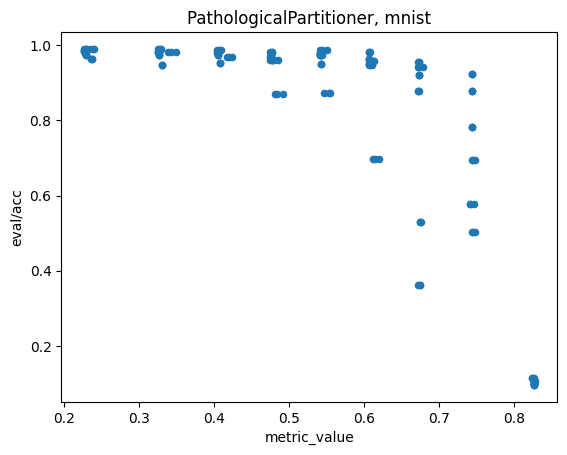

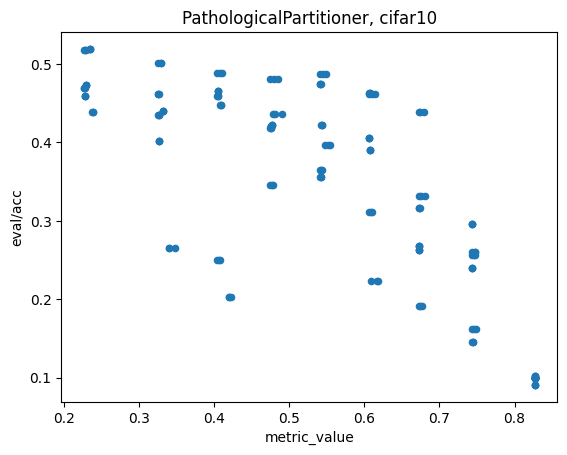

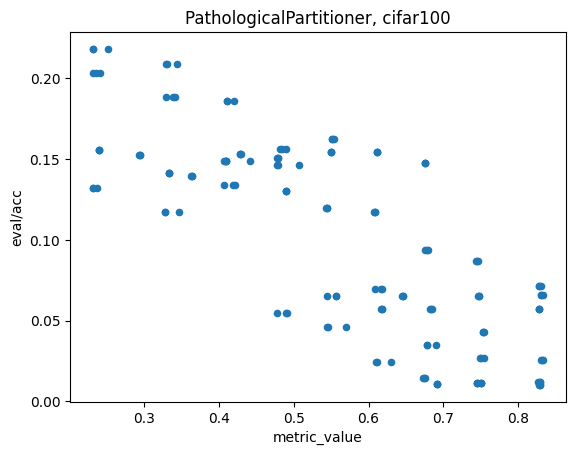

In [24]:
for partitioner_name in ["IidPartitioner", "DirichletPartitioner", "PathologicalPartitioner"]:
    for ds_name in ["mnist", "cifar10", "cifar100"]:
        res, acc, hetero = read_data(ds_name, partitioner_name, mode="single-seed")
        res_dict[(ds_name, partitioner_name)] = res
        acc_dict[(ds_name, partitioner_name)] = acc
        hetero_dict[(ds_name, partitioner_name)] = hetero
        
    # Compute correlations
    for ds_name in ["mnist", "cifar10", "cifar100"]:
        res = res_dict[(ds_name, partitioner_name)]
        corr = res["eval/acc"].corr(res["metric_value"])
        corrs[(ds_name, partitioner_name)] = corr
        print(f"{ds_name}, {partitioner_name} correlation: {corr}")
    print()


    if DISPLAY_DATAFRAMES:
        for ds_name in ["mnist", "cifar10", "cifar100"]:
            print(f"{ds_name}, {partitioner_name}")
            res = res_dict[(ds_name, partitioner_name)]
            display(res)
    print()

    if PLOT_RESULTS:
        for ds_name in ["mnist", "cifar10", "cifar100"]:
            print(f"{ds_name}, {partitioner_name}")
            res = res_dict[(ds_name, partitioner_name)]
            res[["eval/acc", "metric_value"]].plot(
                kind="scatter",
                x="metric_value",
                y="eval/acc",
                title=f"{partitioner_name}, {ds_name}",
            )

    if SAVE_DATAFRAMES:
        for ds_name in ["mnist", "cifar10", "cifar100"]:
            save_acc_results(acc_dict[(ds_name, partitioner_name)], "mnist", partitioner_name)
            # todo: ? the heterogeneity here too? (where the redder is more homogeneous)


## Overview of the Correlation for (Dataset, Partitioner) pairs

In [25]:
df = pd.DataFrame(
    list(corrs.values()),
    index=pd.MultiIndex.from_tuples(corrs.keys()),
    columns=["Value"],
)
df.sort_index().style.background_gradient(cmap="RdYlGn", vmin=-1, vmax=1)

## Overview of the Correlation for (Partitioner, Dataset) pairs

It's a column reordering version of the results above

In [26]:
df = df.reorder_levels([1, 0])
df.sort_index().style.background_gradient(cmap="RdYlGn", vmin=-1, vmax=1)

# Cross Partitioners Comparision Plots

Is there a way of infering acc from training from one partitioning scheme based on the heterogeneity metrics.

## Plotting alone

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import matplotlib.pyplot as plt

In [11]:
pathological_df = res_dict[("cifar10", "IidPartitioner")].dropna()
dirichlet_df = res_dict[("cifar10", "DirichletPartitioner")].dropna()
pathological_df["partitioner"] = p2
dirichlet_df["partitioner"] = "DirichletPartitioner"
df = pd.concat([pathological_df, dirichlet_df])[
    ["metric_value", "eval/acc", "partitioner"]
]
df

/tmp/ipykernel_2604382/2473142055.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


,metric_value,eval/acc,partitioner
0,0.006195,0.6088,PathologicalPartitioner
1,0.014177,0.5715,PathologicalPartitioner
2,0.023834,0.5258,PathologicalPartitioner
3,0.045574,0.4874,PathologicalPartitioner
4,0.079977,0.4839,PathologicalPartitioner
5,0.155471,0.4433,PathologicalPartitioner
0,0.520317,0.5169,DirichletPartitioner
1,0.388491,0.5492,DirichletPartitioner
2,0.249940,0.5990,DirichletPartitioner
3,0.141503,0.6099,DirichletPartitioner


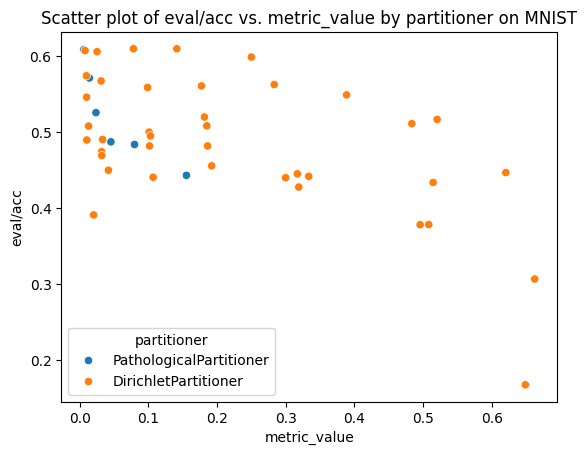

In [12]:
import seaborn as sns

sns.scatterplot(data=df, x="metric_value", y="eval/acc", hue="partitioner")
plt.title("Scatter plot of eval/acc vs. metric_value by partitioner on MNIST")
plt.show()

# Cross partitioner computation

## First try

In [30]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns


iid_df = res_dict[("cifar10", "IidPartitioner")].dropna()
iid_df["partitioner"] = "IidPartitioner"
pathological_df = res_dict[("cifar10", "PathologicalPartitioner")].dropna()
dirichlet_df = res_dict[("cifar10", "DirichletPartitioner")].dropna()
pathological_df["partitioner"] = "PathologicalPartitioner"
dirichlet_df["partitioner"] = "DirichletPartitioner"
df = pd.concat([iid_df, pathological_df, dirichlet_df])[
    ["metric_value", "eval/acc", "partitioner"]
]

# 2. Encode the Group variable
encoder = OneHotEncoder(
    categories=[["IidPartitioner", "DirichletPartitioner", "PathologicalPartitioner"]],
    drop="first",
    sparse_output=False,
)
group_encoded = encoder.fit_transform(df[["partitioner"]])
encoded_feature_names = encoder.get_feature_names_out(["partitioner"])
df_group_encoded = pd.DataFrame(group_encoded, columns=encoded_feature_names)
df_encoded = pd.concat([df.reset_index(drop=True), df_group_encoded], axis=1)
# df_encoded.drop('partitioner', axis=1, inplace=True)

# Create interaction terms manually
for col in encoded_feature_names:
    df_encoded[f"metric_value * {col}"] = df_encoded["metric_value"] * df_encoded[col]

# Define the feature matrix X and target vector y
X = df_encoded[
    ["metric_value"]
    + list(encoded_feature_names)
    + [f"metric_value * {col}" for col in encoded_feature_names]
]
y = df_encoded["eval/acc"]

# Add a constant term to the model (intercept)
X = sm.add_constant(X)

# Fit the linear regression model using statsmodels
model = sm.OLS(y, X).fit()

# Print the summary, which includes p-values, t-values, and other important metrics
print(model.summary())

# # 3. Create interaction terms
# X = df_encoded[['metric_value'] + list(encoded_feature_names)]
# y = df_encoded['eval/acc']
# poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# X_poly = poly.fit_transform(X)
# feature_names = poly.get_feature_names_out(['metric_value'] + list(encoded_feature_names))
# df_features = pd.DataFrame(X_poly, columns=feature_names)
# df_final = pd.concat([df_features, y.reset_index(drop=True)], axis=1)

# # # 4. Prepare feature matrix and target vector
# # X = df_features.drop(['Group_Experiment 2 Group_Experiment 3'], axis=1)
# X = df_features
# y = df_final['eval/acc']

# # 5. Split the data (optional)
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0, random_state=42)
# X_train, y_train = X, y

# # 6. Fit the Linear Regression model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # 7. Print coefficients
# coefficients = pd.DataFrame({
#     'Feature': X.columns,
#     'Coefficient': model.coef_
# })
# print(coefficients)
# print(f"Intercept: {model.intercept_}")

# # 8. Evaluate the model
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print(f"Mean Squared Error: {mse:.4f}")
# print(f"R^2 Score: {r2:.4f}")

# # 9. Visualize the results
# colors = {'Experiment 1': 'blue', 'Experiment 2': 'green', 'Experiment 3': 'red'}
# plt.figure(figsize=(10, 6))
# for grp in df['Group'].unique():
#     idx = df['Group'] == grp
#     plt.scatter(df.loc[idx, 'Metric_A'], df.loc[idx, 'eval/acc'], label=grp, color=colors[grp])
#     metric_a_range = np.linspace(df['Metric_A'].min(), df['Metric_A'].max(), 100)
#     group_encoded = encoder.transform([[grp]]).flatten()
#     group_experiment_2 = group_encoded[0] if 'Group_Experiment 2' in encoded_feature_names else 0
#     group_experiment_3 = group_encoded[1] if 'Group_Experiment 3' in encoded_feature_names else 0
#     metric_a_group_2 = metric_a_range * group_experiment_2
#     metric_a_group_3 = metric_a_range * group_experiment_3
#     X_plot = pd.DataFrame({
#         'Metric_A': metric_a_range,
#         'Group_Experiment 2': group_experiment_2,
#         'Group_Experiment 3': group_experiment_3,
#         'Metric_A Group_Experiment 2': metric_a_group_2,
#         'Metric_A Group_Experiment 3': metric_a_group_3
#     })
#     y_plot = model.predict(X_plot)
#     plt.plot(metric_a_range, y_plot, color=colors[grp], label=f'Fitted Line {grp}')
# plt.xlabel('Metric A')
# plt.ylabel('Metric B')
# plt.title('Linear Regression with Interaction Terms (Three Groups)')
# plt.legend()
# plt.show()

                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     94.09
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           1.50e-54
Time:                        16:25:02   Log-Likelihood:                 276.56
No. Observations:                 246   AIC:                            -541.1
Df Residuals:                     240   BIC:                            -520.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

/tmp/ipykernel_1759571/3308329796.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


## As fnc

In [46]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm


def cmp_two_partitioners(p1, p2, dataset_name):
    print(f"Dataset: {dataset_name}")
    iid_df = res_dict[(dataset_name, "IidPartitioner")].dropna()
    iid_df["partitioner"] = "IidPartitioner"
    pathological_df = res_dict[(dataset_name, "PathologicalPartitioner")].dropna()
    dirichlet_df = res_dict[(dataset_name, "DirichletPartitioner")].dropna()
    pathological_df["partitioner"] = "PathologicalPartitioner"
    dirichlet_df["partitioner"] = "DirichletPartitioner"
    to_concat = []
    if p1 == "IidPartitioner":
        to_concat.append(iid_df)
    elif p1 == "PathologicalPartitioner":
        to_concat.append(pathological_df)
    elif p1 == "DirichletPartitioner":
        to_concat.append(dirichlet_df)
    if p2 == "IidPartitioner":
        to_concat.append(iid_df)
    elif p2 == "PathologicalPartitioner":
        to_concat.append(pathological_df)
    elif p2 == "DirichletPartitioner":
        to_concat.append(dirichlet_df)
    df = pd.concat(to_concat)[
        ["metric_value", "eval/acc", "partitioner"]
    ]
    # 2. Encode the Group variable
    encoder = OneHotEncoder(
        categories=[[p1, p2]],
        drop="first",
        sparse_output=False,
    )
    group_encoded = encoder.fit_transform(df[["partitioner"]])
    encoded_feature_names = encoder.get_feature_names_out(["partitioner"])
    df_group_encoded = pd.DataFrame(group_encoded, columns=encoded_feature_names)
    df_encoded = pd.concat([df.reset_index(drop=True), df_group_encoded], axis=1)
    # df_encoded.drop('partitioner', axis=1, inplace=True)

    # Create interaction terms manually
    for col in encoded_feature_names:
        df_encoded[f"metric_value * {col}"] = (
            df_encoded["metric_value"] * df_encoded[col]
        )

    # Define the feature matrix X and target vector y
    X = df_encoded[
        ["metric_value"]
        + list(encoded_feature_names)
        + [f"metric_value * {col}" for col in encoded_feature_names]
    ]
    y = df_encoded["eval/acc"]

    # Add a constant term to the model (intercept)
    X = sm.add_constant(X)

    # Fit the linear regression model using statsmodels
    model = sm.OLS(y, X).fit()

    # Print the summary, which includes p-values, t-values, and other important metrics
    print(model.summary())

    sns.scatterplot(data=df, x="metric_value", y="eval/acc", hue="partitioner")
    plt.title(
        f"Scatter plot of eval/acc vs. metric_value by partitioner on {dataset_name}"
    )
    plt.show()

Dataset: cifar10
                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     17.00
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           1.24e-08
Time:                        17:05:41   Log-Likelihood:                 107.48
No. Observations:                  84   AIC:                            -207.0
Df Residuals:                      80   BIC:                            -197.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

/tmp/ipykernel_1759571/1815643939.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


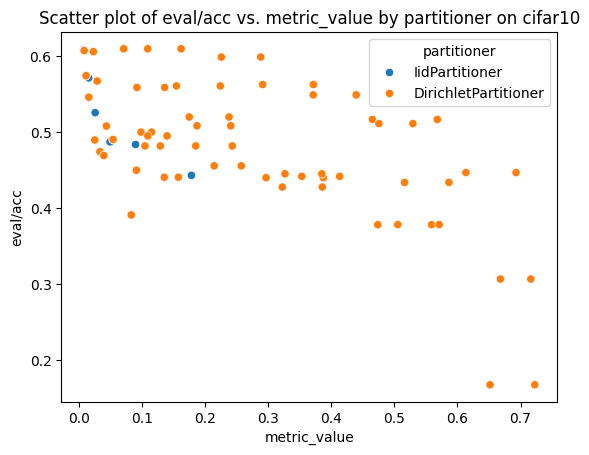

In [47]:
cmp_two_partitioners("IidPartitioner", "DirichletPartitioner", "cifar10")

Dataset: cifar10
    metric_value  eval/acc              partitioner
0       0.743497    0.2563  PathologicalPartitioner
1       0.746825    0.2563  PathologicalPartitioner
2       0.746106    0.2563  PathologicalPartitioner
3       0.675875    0.3311  PathologicalPartitioner
4       0.680590    0.3311  PathologicalPartitioner
..           ...       ...                      ...
79      0.157678    0.4408     DirichletPartitioner
80      0.090270    0.4500     DirichletPartitioner
81      0.091285    0.4500     DirichletPartitioner
82      0.083001    0.3912     DirichletPartitioner
83      0.083001    0.3912     DirichletPartitioner

[240 rows x 3 columns]
                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     149.1
Date:              

/tmp/ipykernel_1759571/3026110954.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = p1


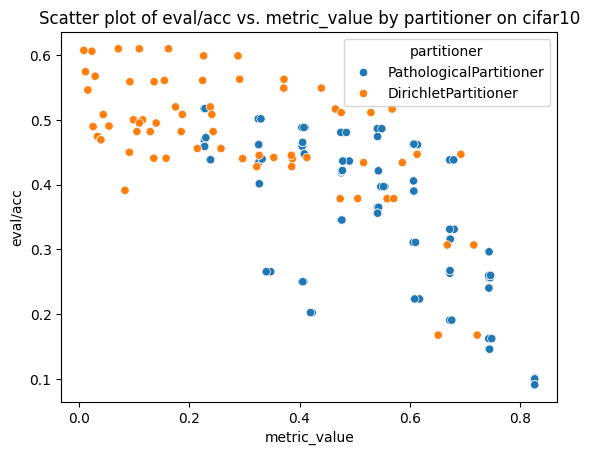

In [35]:
cmp_two_partitioners("DirichletPartitioner", "PathologicalPartitioner", "cifar10")

Dataset: cifar10
                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     85.79
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           2.00e-33
Time:                        17:06:36   Log-Likelihood:                 180.66
No. Observations:                 168   AIC:                            -353.3
Df Residuals:                     164   BIC:                            -340.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

/tmp/ipykernel_1759571/1815643939.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


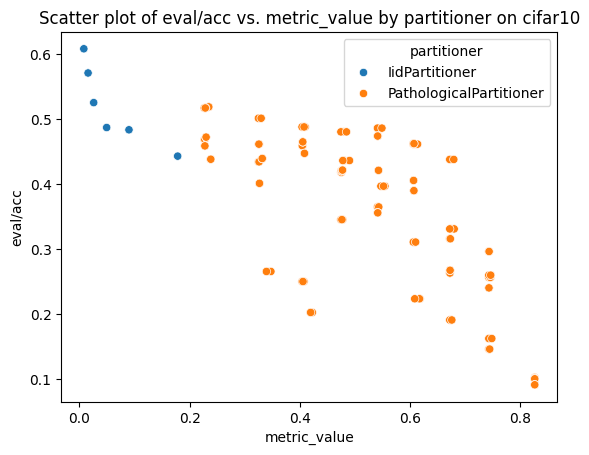

In [48]:
cmp_two_partitioners("IidPartitioner", "PathologicalPartitioner", "cifar10")

Dataset: cifar10
                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     78.30
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           7.94e-29
Time:                        13:15:02   Log-Likelihood:                 153.39
No. Observations:                 132   AIC:                            -298.8
Df Residuals:                     128   BIC:                            -287.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

/tmp/ipykernel_1178096/2959293513.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


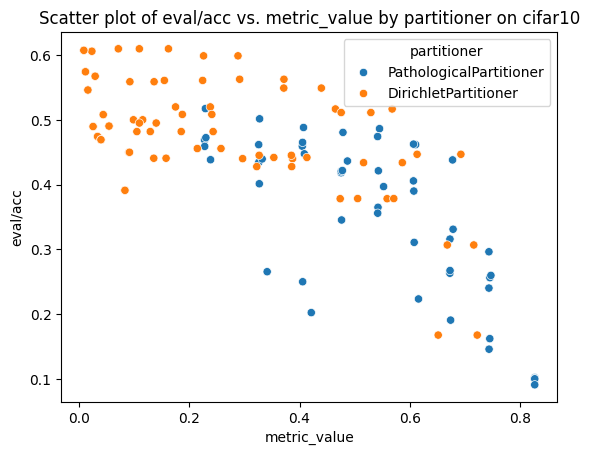

In [64]:
dir_vs_path("cifar10")

Dataset: cifar100
                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     75.20
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           1.08e-27
Time:                        13:15:27   Log-Likelihood:                 222.13
No. Observations:                 127   AIC:                            -436.3
Df Residuals:                     123   BIC:                            -424.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/tmp/ipykernel_1178096/2959293513.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathological_df["partitioner"] = "PathologicalPartitioner"
/tmp/ipykernel_1178096/2959293513.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


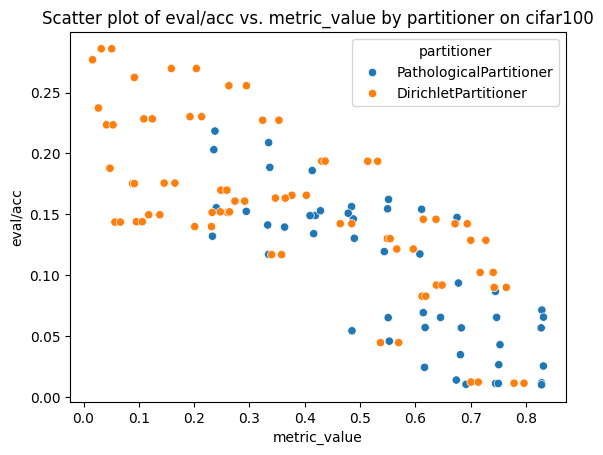

In [65]:
dir_vs_path("cifar100")

# Learn how to do cross partitioner comparison

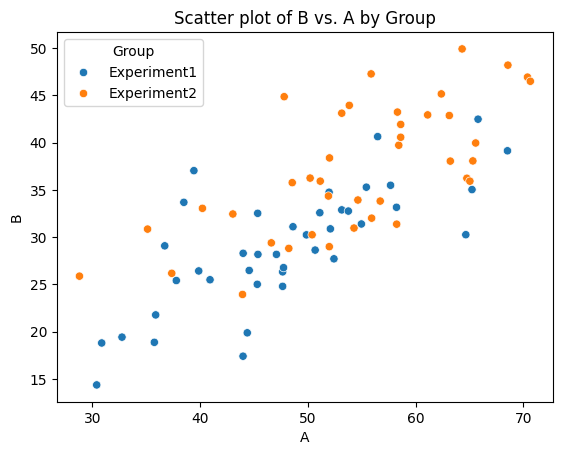

               sum_sq    df          F        PR(>F)
Group      409.070568   1.0  18.709565  4.570192e-05
A         1763.130254   1.0  80.639878  1.458166e-13
A:Group      0.237501   1.0   0.010863  9.172666e-01
Residual  1661.682822  76.0        NaN           NaN
Interaction not significant. Proceeding without interaction term.
               sum_sq    df          F        PR(>F)
Group      409.070568   1.0  18.953035  4.074290e-05
A         1763.130254   1.0  81.689253  1.012162e-13
Residual  1661.920322  77.0        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                      B   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     72.25
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           2.16e-18
Time:                        10:22:45   Log-Likelihood:       

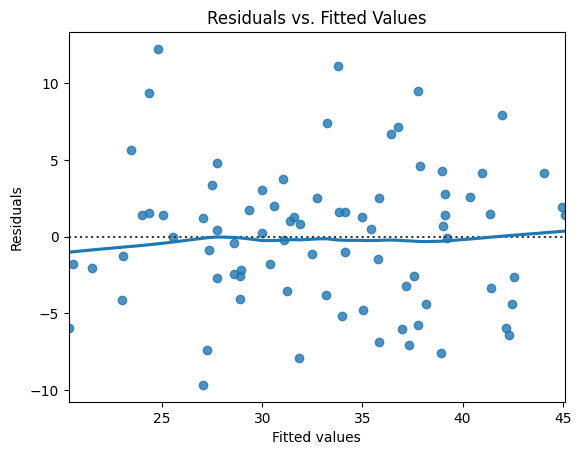

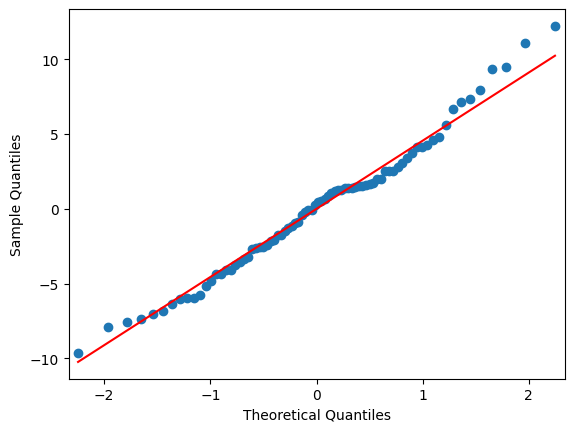

Shapiro-Wilk test statistic: 0.9835345512659741
Shapiro-Wilk p-value: 0.3942912178947833


In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import FTestAnovaPower

# Synthetic data generation
np.random.seed(42)

# Define sample sizes
n1 = 40  # Sample size for Experiment1
n2 = 40  # Sample size for Experiment2

# Generate metric A
A1 = np.random.normal(50, 10, n1)
A2 = np.random.normal(55, 10, n2)

# Generate metric B with some group effect
B1 = 0.5 * A1 + np.random.normal(0, 5, n1) + 5
B2 = 0.5 * A2 + np.random.normal(0, 5, n2) + 10

# Create DataFrames
df1 = pd.DataFrame({"A": A1, "B": B1, "Group": "Experiment1"})
df2 = pd.DataFrame({"A": A2, "B": B2, "Group": "Experiment2"})

# Combine DataFrames
df = pd.concat([df1, df2], ignore_index=True)
df["Group"] = df["Group"].astype("category")

# Visualize data
sns.scatterplot(data=df, x="A", y="B", hue="Group")
plt.title("Scatter plot of B vs. A by Group")
plt.show()

# Test for homogeneity of regression slopes
model_interaction = ols("B ~ A * Group", data=df).fit()
anova_table = sm.stats.anova_lm(model_interaction, typ=2)
print(anova_table)

# Check if interaction is significant
interaction_pvalue = anova_table["PR(>F)"]["A:Group"]
if interaction_pvalue > 0.05:
    print("Interaction not significant. Proceeding without interaction term.")
    # Perform ANCOVA without interaction term
    model = ols("B ~ A + Group", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)
else:
    print("Interaction significant. Including interaction term.")
    model = model_interaction  # Use model with interaction

# Analyze results
print(model.summary())

# Check assumptions
# Residuals vs. Fitted
fitted_vals = model.fittedvalues
residuals = model.resid
sns.residplot(x=fitted_vals, y=residuals, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

# Normality of residuals
sm.qqplot(residuals, line="s")
plt.show()
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

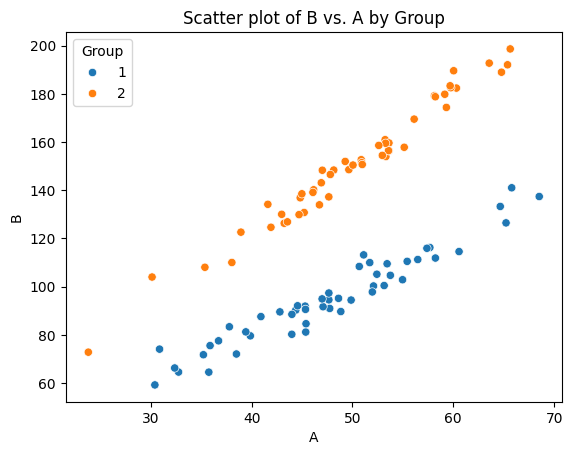

KeyError: 'Group_Experiment2'

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Generate synthetic data
np.random.seed(42)

# Sample sizes
n1 = 50
n2 = 50

# Generate metric A
A1 = np.random.normal(50, 10, n1)
A2 = np.random.normal(50, 10, n2)

# Generate metric B
# Experiment1: B = 2*A + error
B1 = 2 * A1 + np.random.normal(0, 5, n1)

# Experiment2: B = 3*A + error
B2 = 3 * A2 + np.random.normal(0, 5, n2)

# Create DataFrames
df1 = pd.DataFrame({"A": A1, "B": B1})
df2 = pd.DataFrame({"A": A2, "B": B2})

# Add Group indicator
df1["Group"] = 1
df2["Group"] = 2

# Combine DataFrames
df = pd.concat([df1, df2], ignore_index=True)
df["Group"] = df["Group"].astype("category")

# Visualize data
sns.scatterplot(data=df, x="A", y="B", hue="Group")
plt.title("Scatter plot of B vs. A by Group")
plt.show()

# Encode the Group variable
df = pd.get_dummies(df, columns=["Group"], drop_first=True)

# Create interaction term
df["A_Group"] = df["A"] * df["Group_Experiment2"]

# Define independent variables
X = df[["A", "Group_Experiment2", "A_Group"]]
X = sm.add_constant(X)

# Define dependent variable
y = df["B"]

# Fit regression model
model = sm.OLS(np.asarray(y), X).fit()

# View model summary
print(model.summary())

# Check assumptions
# Residuals vs. Fitted
fitted_vals = model.fittedvalues
residuals = model.resid
sns.residplot(x=fitted_vals, y=residuals, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

# Normality of residuals
sm.qqplot(residuals, line="45")
plt.show()
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

# Homoscedasticity
bp_test = het_breuschpagan(residuals, X)
print("Breusch-Pagan test statistic:", bp_test[0])
print("Breusch-Pagan p-value:", bp_test[1])

# Multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Visualize regression lines
# Need to map Group_Experiment2 back to original group labels for plotting
df["Group"] = df["Group_Experiment2"].map({0: "Experiment1", 1: "Experiment2"})
sns.lmplot(
    x="A", y="B", hue="Group", data=df, markers=["o", "x"], palette="Set1", ci=None
)
plt.title("Regression Lines for Each Group")
plt.show()

# Learning how to do cross partitioner comparison 2

## Try out some works

In [25]:
df.columns = ["metric_value", "test_acc", "partitioner"]

In [26]:
model_interaction = ols("test_acc ~ metric_value * partitioner", data=df).fit()
anova_table = sm.stats.anova_lm(model_interaction, typ=2)
print(anova_table)

                            sum_sq    df          F    PR(>F)
partitioner               0.000478   1.0   0.096358  0.757817
metric_value              0.107197   1.0  21.611896  0.000034
metric_value:partitioner  0.007482   1.0   1.508408  0.226386
Residual                  0.203364  41.0        NaN       NaN


                            sum_sq    df          F    PR(>F)
partitioner               0.000478   1.0   0.096358  0.757817
metric_value              0.107197   1.0  21.611896  0.000034
metric_value:partitioner  0.007482   1.0   1.508408  0.226386
Residual                  0.203364  41.0        NaN       NaN
Interaction not significant. Proceeding without interaction term.
                sum_sq    df          F    PR(>F)
partitioner   0.000478   1.0   0.095206  0.759186
metric_value  0.107197   1.0  21.353414  0.000036
Residual      0.210846  42.0        NaN       NaN
                            OLS Regression Results                            
Dep. Variable:               test_acc   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     11.23
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           0.000124
Time:                        

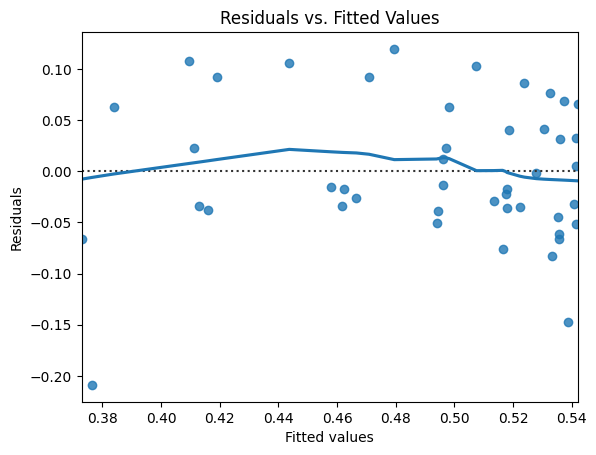

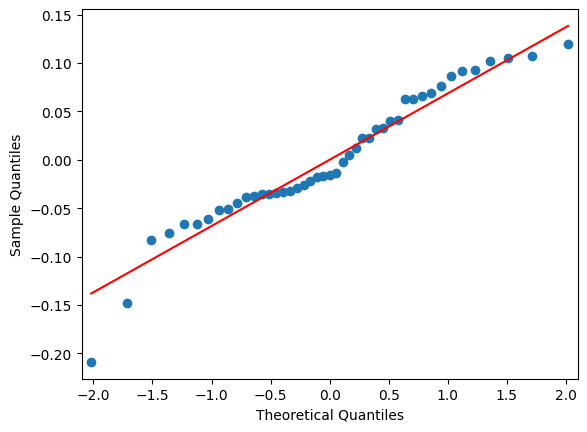

Shapiro-Wilk test statistic: 0.9534392876145992
Shapiro-Wilk p-value: 0.06861713345986872


In [29]:
anova_table = sm.stats.anova_lm(model_interaction, typ=2)
print(anova_table)

# Check if interaction is significant
interaction_pvalue = anova_table["PR(>F)"]["metric_value:partitioner"]
if interaction_pvalue > 0.05:
    print("Interaction not significant. Proceeding without interaction term.")
    # Perform ANCOVA without interaction term
    model = ols("test_acc ~ metric_value + partitioner", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)
else:
    print("Interaction significant. Including interaction term.")
    model = model_interaction  # Use model with interaction

# Analyze results
print(model.summary())

# Check assumptions
# Residuals vs. Fitted
fitted_vals = model.fittedvalues
residuals = model.resid
sns.residplot(x=fitted_vals, y=residuals, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

# Normality of residuals
sm.qqplot(residuals, line="s")
plt.show()
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

<Axes: ylabel='Frequency'>

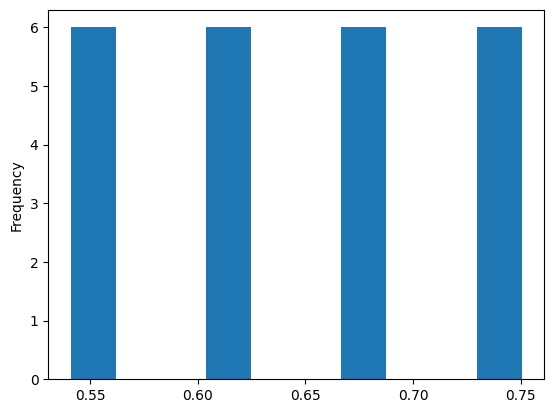

In [29]:
pathological_df["metric_value"].plot.hist()

<Axes: ylabel='Frequency'>

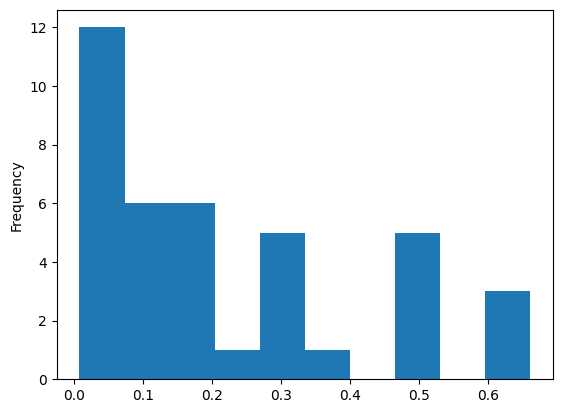

In [30]:
dirichlet_df["metric_value"].plot.hist()

In [31]:
pathological_df["bin"] = pd.cut(
    pathological_df.loc[:, "metric_value"],
    bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    labels=False,
).astype(int)
dirichlet_df["bin"] = pd.cut(
    dirichlet_df.loc[:, "metric_value"],
    bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    labels=False,
).astype(int)

/tmp/ipykernel_645623/1110265417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df['bin'] = pd.cut(dirichlet_df.loc[:, 'metric_value'],  bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], labels=False).astype(int)


<Axes: xlabel='bin'>

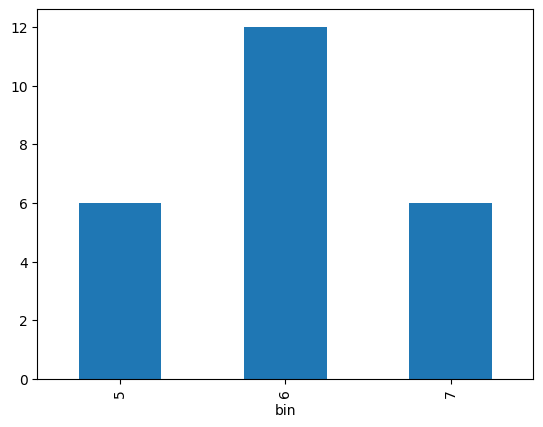

In [34]:
pathological_df["bin"].value_counts().sort_index().plot.bar()

<Axes: xlabel='bin'>

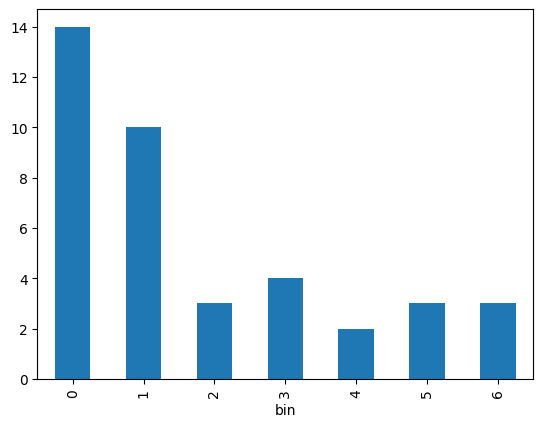

In [35]:
dirichlet_df["bin"].value_counts().sort_index().plot.bar()

In [36]:
# Calculate the correlation for each common bin value
correlations = []
for bin_value in range(5, 6):
    pathological_bin = pathological_df[pathological_df["bin"] == bin_value]
    dirichlet_bin = dirichlet_df[dirichlet_df["bin"] == bin_value]
    correlation = pathological_bin["eval/acc"].corr(dirichlet_bin["eval/acc"])
    correlations.append(correlation)

correlations = np.array(correlations)

# Print the correlations
print(correlations)

[nan]


In [49]:
pathological_df[pathological_df["bin"] == bin_value]["eval/acc"]

3     0.8682
7     0.9827
11    0.9809
15    0.9831
19    0.9719
23    0.9519
Name: eval_acc, dtype: float64

In [52]:
dirichlet_df[dirichlet_df["bin"] == bin_value]["eval/acc"]

0     0.8843
22    0.9713
29    0.9670
Name: eval_acc, dtype: float64

In [37]:
dirichlet_df

,num_partitions,alpha,eval_acc,metric_value,bin
0,3,0.1,0.8843,0.520301,5
1,3,0.3,0.9863,0.388463,3
2,3,1.0,0.9874,0.250478,2
3,3,3.0,0.9886,0.141928,1
4,3,10.0,0.9907,0.078216,0
5,3,100.0,0.9913,0.025358,0
6,3,1000.0,0.9910,0.008000,0
7,10,0.1,0.9174,0.620323,6
8,10,0.3,0.9888,0.482991,4
9,10,1.0,0.9893,0.282998,2


In [38]:
pathological_df

,num_partitions,num_classes_per_partition,eval_acc,metric_value,bin
0,3,2,0.5725,0.743239,7
1,3,3,0.6383,0.680142,6
2,3,4,0.6797,0.618636,6
3,3,5,0.8682,0.551557,5
4,10,2,0.6746,0.750358,7
5,10,3,0.9392,0.678988,6
6,10,4,0.9660,0.613246,6
7,10,5,0.9827,0.546469,5
8,30,2,0.4091,0.746112,7
9,30,3,0.3563,0.674386,6


In [39]:
pathological_bin

,num_partitions,num_classes_per_partition,eval_acc,metric_value,bin
3,3,5,0.8682,0.551557,5
7,10,5,0.9827,0.546469,5
11,30,5,0.9809,0.542557,5
15,100,5,0.9831,0.541341,5
19,300,5,0.9719,0.541064,5
23,1000,5,0.9519,0.541121,5


In [40]:
dirichlet_bin

,num_partitions,alpha,eval_acc,metric_value,bin
0,3,0.1,0.8843,0.520301,5
22,100,0.3,0.9713,0.507179,5
29,300,0.3,0.9670,0.512800,5


# Learn the cross partitioners works 3


Interaction terms:
[[5.48813504 1.         5.48813504]
 [7.15189366 0.         0.        ]
 [6.02763376 1.         6.02763376]
 [5.44883183 0.         0.        ]
 [4.23654799 0.         0.        ]
 [6.45894113 1.         6.45894113]
 [4.37587211 1.         4.37587211]
 [8.91773001 0.         0.        ]
 [9.63662761 0.         0.        ]
 [3.83441519 0.         0.        ]
 [7.91725038 1.         7.91725038]
 [5.2889492  1.         5.2889492 ]
 [5.68044561 0.         0.        ]
 [9.25596638 0.         0.        ]
 [0.71036058 0.         0.        ]
 [0.871293   0.         0.        ]
 [0.20218397 0.         0.        ]
 [8.32619846 1.         8.32619846]
 [7.78156751 0.         0.        ]
 [8.70012148 1.         8.70012148]
 [9.78618342 0.         0.        ]
 [7.99158564 0.         0.        ]
 [4.61479362 0.         0.        ]
 [7.80529176 1.         7.80529176]
 [1.18274426 1.         1.18274426]
 [6.39921021 1.         6.39921021]
 [1.43353287 0.         0.        ]
 [9.44668

/root/.pyenv/versions/3.10.9/envs/fl-heterogeneity/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/root/.pyenv/versions/3.10.9/envs/fl-heterogeneity/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


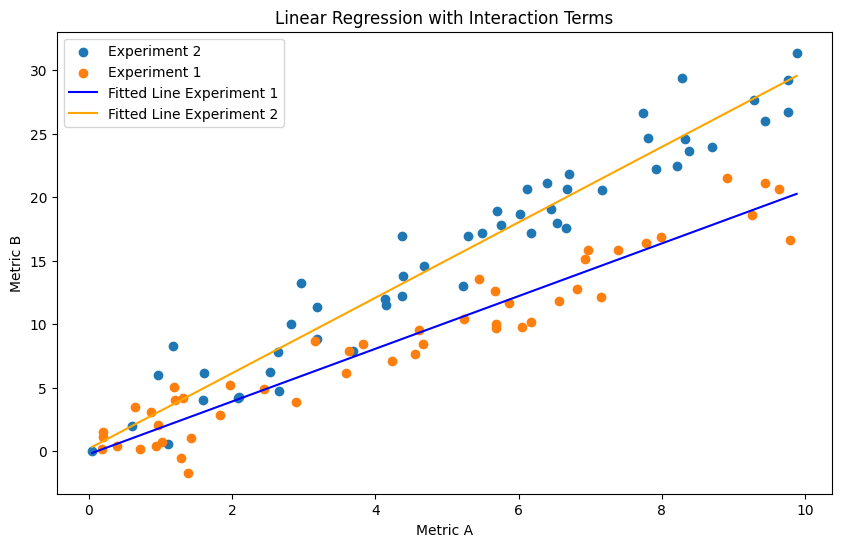

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Create a synthetic dataset
np.random.seed(0)
n_samples = 100
metric_a = np.random.uniform(0, 10, n_samples)
group = np.random.choice(["Experiment 1", "Experiment 2"], size=n_samples)
noise = np.random.normal(0, 2, n_samples)
metric_b = np.where(group == "Experiment 1", 2 * metric_a + noise, 3 * metric_a + noise)
df = pd.DataFrame({"Metric_A": metric_a, "eval/acc": eval / acc, "Group": group})

# 2. Encode the Group variable
encoder = OneHotEncoder(drop="first", sparse_output=False)
group_encoded = encoder.fit_transform(df[["Group"]])
encoded_feature_names = encoder.get_feature_names_out(["Group"])
df_group_encoded = pd.DataFrame(group_encoded, columns=encoded_feature_names)
df_encoded = pd.concat([df.reset_index(drop=True), df_group_encoded], axis=1)
df_encoded.drop("Group", axis=1, inplace=True)

# 3. Create interaction terms
X = df_encoded[["Metric_A", "Group_Experiment 2"]]
y = df_encoded["Metric_B"]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_terms = poly.fit_transform(X)
print("Interaction terms:")
print(interaction_terms)
feature_names = poly.get_feature_names_out(["Metric_A", "Group_Experiment 2"])
df_interactions = pd.DataFrame(interaction_terms, columns=feature_names)
df_final = pd.concat([df_interactions, y.reset_index(drop=True)], axis=1)

# 4. Define X and y
X = df_final.drop("Metric_B", axis=1)
y = df_final["Metric_B"]

# 5. Split the data (optional)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 7. Print coefficients
coefficients = pd.DataFrame({"Feature": X.columns, "Coefficient": model.coef_})
print(coefficients)
print(f"Intercept: {model.intercept_}")

# 8. Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 9. Visualize the results
plt.figure(figsize=(10, 6))
for grp in df["Group"].unique():
    idx = df["Group"] == grp
    plt.scatter(df.loc[idx, "Metric_A"], df.loc[idx, "Metric_B"], label=grp)
metric_a_range = np.linspace(df["Metric_A"].min(), df["Metric_A"].max(), 100)
group_exp1 = np.zeros_like(metric_a_range)
interaction_exp1 = metric_a_range * group_exp1
X_plot_exp1 = np.column_stack([metric_a_range, group_exp1, interaction_exp1])
y_plot_exp1 = model.predict(X_plot_exp1)
group_exp2 = np.ones_like(metric_a_range)
interaction_exp2 = metric_a_range * group_exp2
X_plot_exp2 = np.column_stack([metric_a_range, group_exp2, interaction_exp2])
y_plot_exp2 = model.predict(X_plot_exp2)
plt.plot(metric_a_range, y_plot_exp1, color="blue", label="Fitted Line Experiment 1")
plt.plot(metric_a_range, y_plot_exp2, color="orange", label="Fitted Line Experiment 2")
plt.xlabel("Metric A")
plt.ylabel("Metric B")
plt.title("Linear Regression with Interaction Terms")
plt.legend()
plt.show()

                       Feature  Coefficient
0                     Metric_A     1.902198
1           Group_Experiment 2    -0.088381
2           Group_Experiment 3    -0.823880
3  Metric_A Group_Experiment 2     1.098401
4  Metric_A Group_Experiment 3     2.202400
Intercept: 0.12173576473566605
Mean Squared Error: 3.1376
R^2 Score: 0.9635


/root/.pyenv/versions/3.10.9/envs/fl-heterogeneity/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/root/.pyenv/versions/3.10.9/envs/fl-heterogeneity/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/root/.pyenv/versions/3.10.9/envs/fl-heterogeneity/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


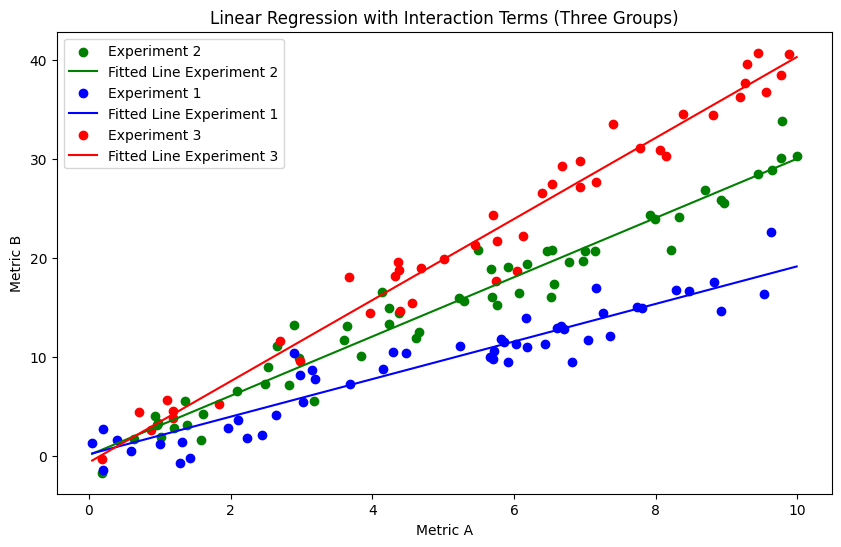

In [13]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Create a synthetic dataset with three groups
np.random.seed(0)
n_samples = 150
metric_a = np.random.uniform(0, 10, n_samples)
group = np.random.choice(
    ["Experiment 1", "Experiment 2", "Experiment 3"], size=n_samples
)
noise = np.random.normal(0, 2, n_samples)
metric_b = np.where(
    group == "Experiment 1",
    2 * metric_a + noise,
    np.where(group == "Experiment 2", 3 * metric_a + noise, 4 * metric_a + noise),
)
df = pd.DataFrame({"Metric_A": metric_a, "Metric_B": metric_b, "Group": group})

# 2. Encode the Group variable
encoder = OneHotEncoder(drop="first", sparse_output=False)
group_encoded = encoder.fit_transform(df[["Group"]])
encoded_feature_names = encoder.get_feature_names_out(["Group"])
df_group_encoded = pd.DataFrame(group_encoded, columns=encoded_feature_names)
df_encoded = pd.concat([df.reset_index(drop=True), df_group_encoded], axis=1)
df_encoded.drop("Group", axis=1, inplace=True)

# 3. Create interaction terms
X = df_encoded[["Metric_A"] + list(encoded_feature_names)]
y = df_encoded["Metric_B"]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(["Metric_A"] + list(encoded_feature_names))
df_features = pd.DataFrame(X_poly, columns=feature_names)
df_final = pd.concat([df_features, y.reset_index(drop=True)], axis=1)

# 4. Prepare feature matrix and target vector
X = df_features.drop(["Group_Experiment 2 Group_Experiment 3"], axis=1)
y = df_final["Metric_B"]

# 5. Split the data (optional)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 7. Print coefficients
coefficients = pd.DataFrame({"Feature": X.columns, "Coefficient": model.coef_})
print(coefficients)
print(f"Intercept: {model.intercept_}")

# 8. Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 9. Visualize the results
colors = {"Experiment 1": "blue", "Experiment 2": "green", "Experiment 3": "red"}
plt.figure(figsize=(10, 6))
for grp in df["Group"].unique():
    idx = df["Group"] == grp
    plt.scatter(
        df.loc[idx, "Metric_A"], df.loc[idx, "Metric_B"], label=grp, color=colors[grp]
    )
    metric_a_range = np.linspace(df["Metric_A"].min(), df["Metric_A"].max(), 100)
    group_encoded = encoder.transform([[grp]]).flatten()
    group_experiment_2 = (
        group_encoded[0] if "Group_Experiment 2" in encoded_feature_names else 0
    )
    group_experiment_3 = (
        group_encoded[1] if "Group_Experiment 3" in encoded_feature_names else 0
    )
    metric_a_group_2 = metric_a_range * group_experiment_2
    metric_a_group_3 = metric_a_range * group_experiment_3
    X_plot = pd.DataFrame(
        {
            "Metric_A": metric_a_range,
            "Group_Experiment 2": group_experiment_2,
            "Group_Experiment 3": group_experiment_3,
            "Metric_A Group_Experiment 2": metric_a_group_2,
            "Metric_A Group_Experiment 3": metric_a_group_3,
        }
    )
    y_plot = model.predict(X_plot)
    plt.plot(metric_a_range, y_plot, color=colors[grp], label=f"Fitted Line {grp}")
plt.xlabel("Metric A")
plt.ylabel("Metric B")
plt.title("Linear Regression with Interaction Terms (Three Groups)")
plt.legend()
plt.show()

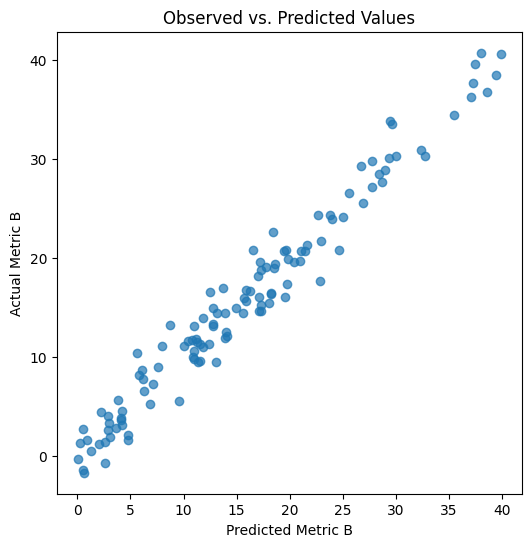

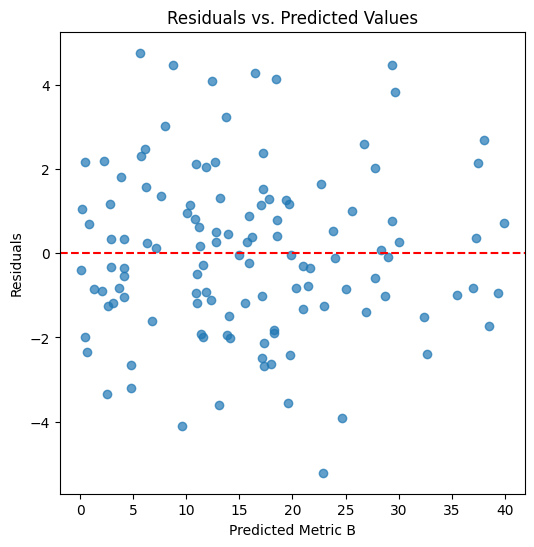

In [26]:
# Predict on the training set
y_train_pred = model.predict(X_train)

# Plot observed vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_train_pred, y_train, alpha=0.7)
plt.xlabel("Predicted Metric B")
plt.ylabel("Actual Metric B")
plt.title("Observed vs. Predicted Values")
plt.show()

# Plot residuals vs. predicted values
residuals = y_train - y_train_pred
plt.figure(figsize=(6, 6))
plt.scatter(y_train_pred, residuals, alpha=0.7)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Metric B")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

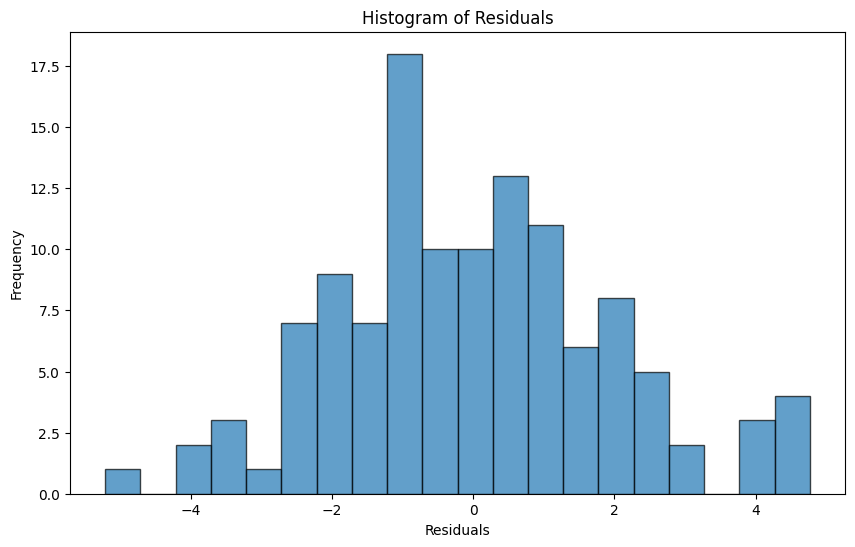

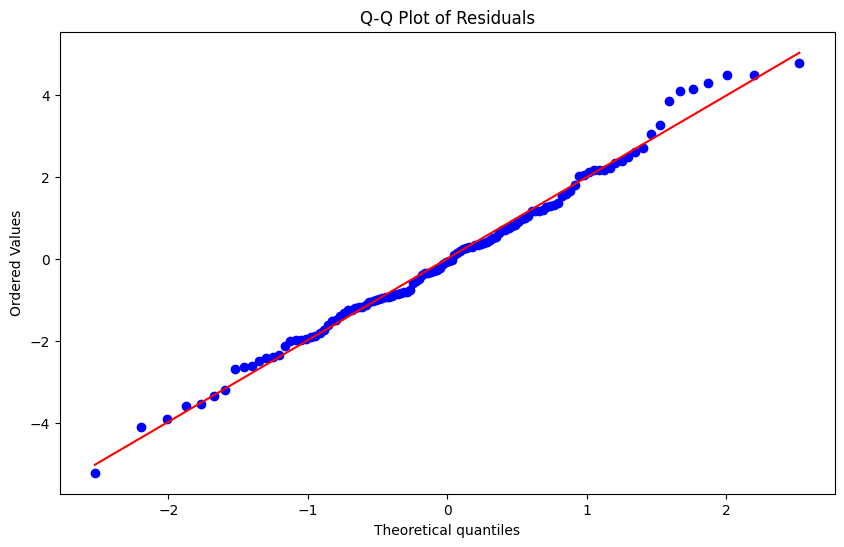

Shapiro-Wilk Test Statistic: 0.9906, p-value: 0.5921


In [27]:
import scipy.stats as stats

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor="k", alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals)
print(
    f"Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}"
)

In [28]:
# Add an intercept term to X_train
import numpy.linalg as la

# Number of observations and predictors
n = X_train.shape[0]
p = X_train.shape[1] + 1  # +1 for the intercept

# Add intercept to X_train
X_train_intercept = np.column_stack((np.ones(n), X_train.values))

# Calculate predictions and residuals
y_train_pred = model.predict(X_train)
residuals = y_train - y_train_pred

# Estimate of the variance of the residuals
s_squared = np.sum(residuals**2) / (n - p)

# Calculate the covariance matrix of the coefficients
XTX_inv = la.inv(np.dot(X_train_intercept.T, X_train_intercept))
cov_beta = s_squared * XTX_inv

# Standard errors of the coefficients
standard_errors = np.sqrt(np.diag(cov_beta))

# Coefficient estimates (including intercept)
coefficients = np.concatenate(([model.intercept_], model.coef_))

# t-statistics
t_stats = coefficients / standard_errors

# Degrees of freedom
df = n - p

# Two-tailed p-values
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]

# Create a DataFrame to display results
coef_summary = pd.DataFrame(
    {
        "Coefficient": coefficients,
        "Standard Error": standard_errors,
        "t-value": t_stats,
        "p-value": p_values,
    },
    index=["Intercept"] + list(X_train.columns),
)

print(coef_summary)

                             Coefficient  Standard Error    t-value  \
Intercept                       0.121736        0.646841   0.188201   
Metric_A                        1.902198        0.115467  16.473932   
Group_Experiment 2             -0.088381        0.918820  -0.096189   
Group_Experiment 3             -0.823880        0.958576  -0.859483   
Metric_A Group_Experiment 2     1.098401        0.159251   6.897311   
Metric_A Group_Experiment 3     2.202400        0.161862  13.606635   

                                  p-value  
Intercept                    8.510541e-01  
Metric_A                     0.000000e+00  
Group_Experiment 2           9.235390e-01  
Group_Experiment 3           3.918776e-01  
Metric_A Group_Experiment 2  3.133667e-10  
Metric_A Group_Experiment 3  0.000000e+00  
